### COURSERA | IBM DATA SCIENCE | LOAN CLASSIFIER
The purpose of this program is to construct various models to predict whether a customer will pay off or default on a loan based on several factors such as age, education, etc. <br> Models include K-Nearest Neighbors (finding optimal K), Decision Tree, Support Vector Machine, and Logistic Regression. <br> Model evaluation included accuracy, F1 Score, Jaccard Index, and Log Loss when applicable <br><br>
Data were split into training and testing which were respectively used to train and test models. <br> This program uses loan data provided by Coursera.

#### PART 1: DOWNLOAD & CLEAN LOAN DATA

In [1]:
import pandas as pd
import numpy as np

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
print('SUCCESSFULLY DOWNLOADED FILE')

--2019-08-15 01:23:30--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-08-15 01:23:30 (10.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]

SUCCESSFULLY DOWNLOADED FILE


The __loan_train.csv__ dataset includes data regarding 346 customers whose loan was either paid off or defaulted. Attributes include the following:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan Status    | Loan is Paid Off or in Collection                                                     |
| Principal      | Principal Loan Amount                                                                 |
| Terms          | Weekly, Biweekly, or Monthly Payoff Schedule                                          |
| Effective Date | Loan Date                                                                             |
| Due Date       | One-Time Payoff Date                                                                  |
| Age            | Age of Applicant                                                                      |
| Education      | Education of Applicant                                                                |
| Gender         | Gender of Applicant                                                                   |

In [3]:
df = pd.read_csv('loan_train.csv')
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
df.columns = ['Loan Status', 'Principal', 'Terms', 'Effective Date', 'Due Date', 'Age', 'Education', 'Gender']
df['Education'].replace('Bechalor', 'Bachelor', inplace=True)
df['Education'].replace('college', 'College', inplace=True)
df['Gender'].replace('male', 'M', inplace=True)
df['Gender'].replace('female', 'F', inplace=True)
df.head()

,Loan Status,Principal,Terms,Effective Date,Due Date,Age,Education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,M
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bachelor,F
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,College,M
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,College,F
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,College,M


In [4]:
print('ENTRIES IN DATAFRAME:', len(df))

ENTRIES IN DATAFRAME: 346


In [5]:
df['Due Date'] = pd.to_datetime(df['Due Date'])
df['Effective Date'] = pd.to_datetime(df['Effective Date'])
df.head()

,Loan Status,Principal,Terms,Effective Date,Due Date,Age,Education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,M
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,F
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,College,M
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,College,F
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,College,M


In [6]:
df['Loan Status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: Loan Status, dtype: int64

#### PART 2: FEATURE SELECTION & EXTRACTION

In [7]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from sklearn import preprocessing
%matplotlib inline

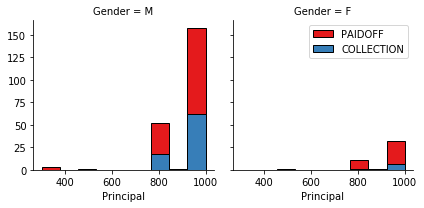

In [8]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="Loan Status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

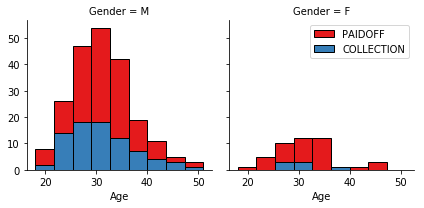

In [9]:
bins = np.linspace(df.Age.min(), df.Age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="Loan Status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Age', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

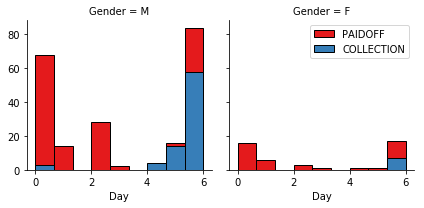

In [10]:
df['Day'] = df['Effective Date'].dt.dayofweek
bins = np.linspace(df.Day.min(), df.Day.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="Loan Status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Day', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

#### PART 3: ONEHOT ENCODE, NORMALIZE, & SPLIT DATA

In [11]:
df['Weekend'] = df['Day'].apply(lambda x: 1 if (x>3) else 0)
df.head()

,Loan Status,Principal,Terms,Effective Date,Due Date,Age,Education,Gender,Day,Weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,M,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,F,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,College,M,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,College,F,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,College,M,4,1


In [12]:
df.groupby(['Gender'])['Loan Status'].value_counts(normalize=True)

Gender  Loan Status
F       PAIDOFF        0.865385
        COLLECTION     0.134615
M       PAIDOFF        0.731293
        COLLECTION     0.268707
Name: Loan Status, dtype: float64

In [13]:
df['Gender'].replace(to_replace=['M','F'], value=[0,1], inplace=True)
df.head()

,Loan Status,Principal,Terms,Effective Date,Due Date,Age,Education,Gender,Day,Weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,College,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,College,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,College,0,4,1


In [14]:
df.groupby(['Education'])['Loan Status'].value_counts(normalize=True)

Education             Loan Status
Bachelor              PAIDOFF        0.750000
                      COLLECTION     0.250000
College               PAIDOFF        0.765101
                      COLLECTION     0.234899
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
Name: Loan Status, dtype: float64

In [15]:
features_df = df[['Principal', 'Terms', 'Age', 'Gender', 'Weekend']]
features_df = pd.concat([features_df, pd.get_dummies(df['Education'])], axis=1)
features_df.drop(['Master or Above'], axis = 1, inplace=True)
features_df.head()

,Principal,Terms,Age,Gender,Weekend,Bachelor,College,High School or Below
0,1000,30,45,0,0,0,0,1
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,1,0
3,1000,30,28,1,1,0,1,0
4,1000,30,29,0,1,0,1,0


In [16]:
X = features_df
Y = df['Loan Status'].values
X = preprocessing.StandardScaler().fit(X).transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4)
print ('Training Set:', len(x_train))
print ('Test Set:', len(x_test))

Training Set: 276
Test Set: 70


#### PART 4A: CONSTRUCT K-NEAREST NEIGHBOR MODEL

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'A' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'c' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'c' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/

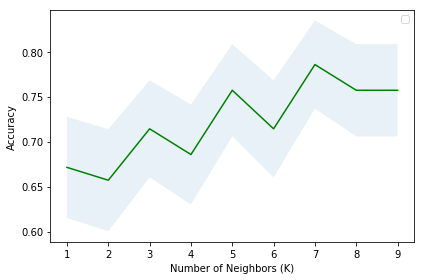

In [19]:
kmax = 10
mean_acc = np.zeros(kmax-1)
std_acc = np.zeros(kmax-1)
for n in range(1, kmax):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train, y_train)
    yhat = neigh.predict(x_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]= np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
plt.plot(range(1, kmax), mean_acc, 'g')
plt.fill_between(range(1, kmax), mean_acc-1*std_acc, mean_acc+1*std_acc, alpha=0.1)
plt.legend('Accuracy', '+/- 3 STD')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [20]:
kopt = 7
neigh = KNeighborsClassifier(n_neighbors = kopt).fit(x_train, y_train)
yhat = neigh.predict(x_test)
kopt_acc = metrics.accuracy_score(y_test, yhat)
print('Optimal K:', kopt)
print('Accuracy:', kopt_acc)

Optimal K: 7
Accuracy: 0.7857142857142857


#### PART 4B: CONSTRUCT DECISION TREE MODEL

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4).fit(x_train, y_train)
yhat = tree.predict(x_test)
tree_acc = metrics.accuracy_score(y_test, yhat)
print('Accuracy:', tree_acc)

Accuracy: 0.6142857142857143


#### PART 4C: CONSTRUCT SUPPORT VECTOR MACHINE MODEL

In [23]:
from sklearn import svm

In [24]:
clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
yhat = clf.predict(x_test)
clf_acc = metrics.accuracy_score(y_test, yhat)
print('Accuracy:', clf_acc)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.7428571428571429


#### PART 4D: CONSTRUCT LOGISTIC REGRESSION MODEL

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [26]:
logreg = LogisticRegression(C=0.01, solver='liblinear').fit(x_train, y_train)
yhat = logreg.predict(x_test)
lr_acc = metrics.accuracy_score(y_test, yhat)
print('Accuracy:', lr_acc)

Accuracy: 0.6857142857142857


#### PART 5: MODEL EVALUATION

In [27]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [28]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
print('SUCCESSFULLY DOWNLOADED FILE')

--2019-08-15 01:23:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-08-15 01:23:34 (257 MB/s) - ‘loan_test.csv’ saved [3642/3642]

SUCCESSFULLY DOWNLOADED FILE


In [29]:
df_test = pd.read_csv('loan_test.csv')
df_test.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
df_test.columns = ['Loan Status', 'Principal', 'Terms', 'Effective Date', 'Due Date', 'Age', 'Education', 'Gender']
df_test['Education'].replace('Bechalor', 'Bachelor', inplace=True)
df_test['Education'].replace('college', 'College', inplace=True)
df_test['Gender'].replace('male', 'M', inplace=True)
df_test['Gender'].replace('female', 'F', inplace=True)

df_test['Due Date'] = pd.to_datetime(df_test['Due Date'])
df_test['Effective Date'] = pd.to_datetime(df_test['Effective Date'])
df_test['Day'] = df_test['Effective Date'].dt.dayofweek
df_test['Weekend'] = df_test['Day'].apply(lambda x: 1 if (x>3) else 0)
df_test['Gender'].replace(to_replace=['M','F'], value=[0,1], inplace=True)
df_test.head()

,Loan Status,Principal,Terms,Effective Date,Due Date,Age,Education,Gender,Day,Weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bachelor,1,3,0
1,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,College,0,5,1
4,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bachelor,0,6,1


In [30]:
x_test = df_test[['Principal', 'Terms', 'Age', 'Gender', 'Weekend']]
x_test = pd.concat([x_test, pd.get_dummies(df_test['Education'])], axis=1)
x_test.drop(['Master or Above'], axis=1, inplace=True)

y_test = df_test['Loan Status'].values
x_test = preprocessing.StandardScaler().fit(x_test).transform(x_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [31]:
yhat_test = neigh.predict(x_test)
knn_acc = metrics.accuracy_score(y_test, yhat_test)
knn_f1 = f1_score(y_test, yhat_test, average='weighted')
knn_jc = jaccard_similarity_score(y_test, yhat_test)
print('Optimal K:', kopt)
print('Accuracy:', knn_acc)
print('F1 Score:', knn_f1)
print('Jaccard Index:', knn_jc)

Optimal K: 7
Accuracy: 0.6666666666666666
F1 Score: 0.6328400281888654
Jaccard Index: 0.6666666666666666


In [32]:
yhat_test = tree.predict(x_test)
tree_acc = metrics.accuracy_score(y_test, yhat_test)
tree_f1 = f1_score(y_test, yhat_test, average='weighted')
tree_jc = jaccard_similarity_score(y_test, yhat_test)
print('Accuracy:', tree_acc)
print('F1 Score:', tree_f1)
print('Jaccard Index:', tree_jc)

Accuracy: 0.7222222222222222
F1 Score: 0.7366818873668188
Jaccard Index: 0.7222222222222222


In [33]:
yhat_test = clf.predict(x_test)
clf_acc = metrics.accuracy_score(y_test, yhat_test)
clf_f1 = f1_score(y_test, yhat_test, average='weighted')
clf_jc = jaccard_similarity_score(y_test, yhat_test)
print('Accuracy:', clf_acc)
print('F1 Score:', clf_f1)
print('Jaccard Index:', clf_jc)

Accuracy: 0.7962962962962963
F1 Score: 0.7583503077293734
Jaccard Index: 0.7962962962962963


In [34]:
yhat_test = logreg.predict(x_test)
lr_acc = metrics.accuracy_score(y_test, yhat_test)
lr_f1 = f1_score(y_test, yhat_test, average='weighted')
lr_jc = jaccard_similarity_score(y_test, yhat_test)
yhat_prob = logreg.predict_proba(x_test)
lr_ll = log_loss(y_test, yhat_prob)
print('Accuracy:', lr_acc)
print('F1 Score:', lr_f1)
print('Jaccard Index:', lr_jc)
print('Log Loss:', lr_ll)

Accuracy: 0.7407407407407407
F1 Score: 0.6604267310789049
Jaccard Index: 0.7407407407407407
Log Loss: 0.5672153379912981


| Algorithm           | Jaccard Index| F1 Score | Log Loss |
|---------------------|--------------|----------|----------|
| KNN                 | 0.667        | 0.633    | N/A      |
| Decision Tree       | 0.722        | 0.737    | N/A      |
| SVM                 | 0.796        | 0.758    | N/A      |
| Logistic Regression | 0.741        | 0.660    | 0.567    |